In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import scipy as sp

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

In [2]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
train_df = pd.read_csv('../train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('../test_sessions.csv', index_col='session_id')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [5]:
sites = ['site%s' % i for i in range(1,11)]
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [6]:
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [7]:
train_df.sort_values(by='time1', inplace=True)

In [8]:
train_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [13]:
#train_df[sites] = train_df[sites].fillna(0).astype('int')
#test_df[sites] = test_df[sites].fillna(0).astype('int')

In [9]:
with open(r"../site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [10]:
y_train = train_df['target']
df = pd.concat([train_df.drop('target', axis=1), test_df])
full_sites = df[sites]
idx_split = train_df.shape[0]

In [11]:
sites_flatten = full_sites.values.flatten()
sites_flatten

array([  56,   55,    0, ..., 1098, 1098, 1098])

In [12]:
full_sites_sparse = sp.sparse.csr_matrix(([1]*sites_flatten.shape[0], 
                                          sites_flatten, 
                                          range(0, sites_flatten.shape[0] + full_sites.shape[1],full_sites.shape[1])))[:, 1:]

In [13]:
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]
X_test = full_sites_sparse[idx_split:, :]

In [14]:
#v_params = {'stop_words':[[' ','  ',','], None],
#            'ngram_range': [(1, 3), (1, 4), (1, 5)],
#            'max_features': [50000, 100000, 200000],
#            'max_df': [0.5, 0.7, 0.9]}

In [15]:
v = TfidfVectorizer(stop_words=[' ','  ',','], ngram_range=(1, 6), max_features=200000, max_df=0.5)

In [16]:
full_sites_str = ["".join(str(sites)) for sites in df[sites].values]
full_sites_str

['[56 55  0  0  0  0  0  0  0  0]',
 '[56 55 56 55  0  0  0  0  0  0]',
 '[946 946 951 946 946 945 948 784 949 946]',
 '[945 948 949 948 945 946 947 945 946 946]',
 '[947 950 948 947 950 952 946 951 946 947]',
 '[952 947 953 946 947 946 953 955 946 947]',
 '[ 953  947  946  953  955  947  953  946  953 1033]',
 '[946 947 954 953 946 954 946 956 957 956]',
 '[946 956 946 946 955 954 946 946 946 948]',
 '[948 946 948 784  49  53 812 982  52  52]',
 '[ 52  52  52 747 747 747  23 747 568  23]',
 '[ 513 1116  747   23  747  747   29   49   52   21]',
 '[4222 3358 4222 3356 4222 3870   21 3870 3358   21]',
 '[38667   181    23   181 38667    23   182   181 38667    55]',
 '[ 56  55 679 676 814  22  39 815 752  50]',
 '[ 570   23   21 3356   48  222  570  513 1379   21]',
 '[820 820 980  49  56  55  49 784 222  50]',
 '[48 56 55 55  0  0  0  0  0  0]',
 '[5898 5898 5794   21 5794 5794   21  182   23  181]',
 '[2570 2570   21   21 1102 1102   23  570  707   21]',
 '[  22   39 1102   21 1102 11

In [17]:
tfidf = v.fit_transform(full_sites_str)

In [18]:
tfidf

<336358x200000 sparse matrix of type '<class 'numpy.float64'>'
	with 6263850 stored elements in Compressed Sparse Row format>

### Features

In [19]:
hosts = pd.read_pickle('../site_dic.pkl')
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # switch key and value

hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

hosts.drop(['name','split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True) # rename index for the future merge
df = pd.merge(df, hosts, how='left', on='site1')

In [68]:
df['min'] = df[times].min(axis=1)
df['max'] = df[times].max(axis=1)
df['seconds'] = ((df['max'] - df['min']) / np.timedelta64(1, 's'))
#df['minutes'] = ((df['max'] - df['min']) / np.timedelta64(1, 'm')).round(2)
df.drop(['min','max'], inplace=True, axis=1)
df['short'] = df['minutes'].map(lambda x: x < 0.8).astype(np.int8)
df['long'] = df['minutes'].map(lambda x: x >= 0.8).astype(np.int8)

In [21]:
df['big_site'] = df['len'].apply(lambda x: x > 5).astype(np.int8)
df['typical_site'] = df['len'].apply(lambda x: x == 3).astype(np.int8)
df['typical_domain'] = df['domain'].map(lambda x: x in ('com', 'fr', 'net', 'uk', 'org', 'tv')).astype(np.int)

In [22]:
df['YearMonth'] = df['time1'].apply(lambda x:x.strftime('%Y%m')).astype('int64')
#df['Year'] = df['time1'].apply(lambda x:x.strftime('%Y')).astype('int64')
#df['Month'] = df.time1.dt.strftime('%m').astype('int64')
df['YearDay'] = df['time1'].apply(lambda x:x.strftime('%j')).astype('int64')
df['is_weekend'] = df['time1'].apply(lambda x: 1 if x.date().weekday() in (5,6) else 0)
df['wed'] = df['time1'].apply(lambda x: 1 if x.date().weekday() in [2] else 0)
df['Hour'] = df.time1.apply(lambda x:x.strftime('%H')).astype('int64')
#df['Week'] = df['time1'].dt.strftime('%W').astype('int64')
df['Day_of_week'] = df['time1'].dt.strftime('%w').astype('int64')

In [23]:
df['Day'] = df.Hour.apply(lambda x:1 if x in range(12,18) else 0)
df['Eve'] = df.Hour.apply(lambda x:1 if x in range(18,22) else 0)
df['Night'] = df.Hour.apply(lambda x:1 if x in range(22,7) else 0)
df['Morning'] = df.Hour.apply(lambda x:1 if x in range(7,12) else 0)

In [24]:
df['is_summer'] = df['Month'].apply(lambda x: 1 if x in (6, 7, 8) else 0)

In [54]:
enc = OneHotEncoder()

In [56]:
#y = enc.fit_transform(df[['Year']].as_matrix())
#m = enc.fit_transform(df[['Month']].as_matrix())
hour = enc.fit_transform(df[['Hour']].as_matrix())
dayweek = enc.fit_transform(df[['Day_of_week']].as_matrix())
yday = enc.fit_transform(df[['YearDay']].as_matrix())
ym = enc.fit_transform(df[['YearMonth']].as_matrix())
#minutes = enc.fit_transform(df[['minutes']].as_matrix())
seconds = enc.fit_transform(df[['seconds']].as_matrix())
lenn = enc.fit_transform(df[['len']].as_matrix())

In [96]:
hour

<336358x17 sparse matrix of type '<class 'numpy.float64'>'
	with 336358 stored elements in Compressed Sparse Row format>

In [57]:
df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,is_weekend,wed,Hour,Week,Day_of_week,Day,Eve,Night,Morning,is_summer
0,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,1,0,8,1,6,0,0,0,1,0
1,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,1,0,8,1,6,0,0,0,1,0
2,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,1,0,8,1,6,0,0,0,1,0
3,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,1,0,8,1,6,0,0,0,1,0
4,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,1,0,8,1,6,0,0,0,1,0


In [82]:
features_to_scale = [
    'seconds',
]
df[features_to_scale] = StandardScaler().fit_transform(df[features_to_scale])

In [83]:
df['len'].head(5)

0    1.471512
1    1.471512
2   -0.242879
3   -0.242879
4    1.471512
Name: len, dtype: float64

In [41]:
df2 = df.drop((df[times]),axis=1).drop((df[sites]),axis=1)

In [252]:
df2 = pd.get_dummies(df2, columns=[
    'YearMonth',
    'YearDay',
    'Hour',
    'Day_of_week',
    
])

In [98]:
full_feat = sp.sparse.hstack([tfidf, 
                              dayweek, 
                              #hour,  
                              yday, 
                              ym,
                              lenn,
                              df.seconds.values.reshape(-1, 1), 
                              df.short.values.reshape(-1, 1),
                              df.long.values.reshape(-1, 1),
                              df.big_site.values.reshape(-1, 1),
                              df.typical_site.values.reshape(-1, 1),
                              df.typical_domain.values.reshape(-1, 1),
                              df.is_summer.values.reshape(-1, 1), 
                              df.wed.values.reshape(-1, 1),
                              df.is_weekend.values.reshape(-1, 1), 
                              df.Night.values.reshape(-1, 1), 
                              df.Day.values.reshape(-1, 1), 
                              df.Morning.values.reshape(-1, 1), 
                              df.Eve.values.reshape(-1, 1)]).tocsr()

In [99]:
Xfull_train = full_feat[:idx_split, :]
Xfull_test = full_feat[idx_split:, :]

In [100]:
# time awared CrossValidation
time_split = TimeSeriesSplit(n_splits=10)

In [68]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

In [101]:
logit = LogisticRegression(solver='liblinear', C=2, penalty='l2', random_state=17)

In [183]:
gs.fit(Xfull_train, y_train)
print ("Best score: {} with parameters:{}".format(gs.best_score_, gs.best_params_))

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 85.3min finished


Best score: 0.9892714401527798 with parameters:{'C': 2, 'penalty': 'l2'}


In [102]:
%%time

cv_scores = cross_val_score(logit, Xfull_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

CPU times: user 77.7 ms, sys: 52.1 ms, total: 130 ms
Wall time: 27.6 s


In [105]:
cv_scores, cv_scores.mean() #scaled seconds, no hour

(array([0.82412613, 0.92726735, 0.85853037, 0.97394599, 0.88941095,
        0.97831934, 0.92555755, 0.96752022, 0.86310368, 0.97495831]),
 0.91827398723559)

In [89]:
cv_scores, cv_scores.mean() #scaled seconds, len

(array([0.66119634, 0.91968635, 0.91843372, 0.96233555, 0.92398284,
        0.98845224, 0.84687315, 0.97075698, 0.90374204, 0.9881804 ]),
 0.9083639597481854)

In [75]:
cv_scores, cv_scores.mean() #no year,month,week,minutes! 

(array([0.66335313, 0.92084987, 0.91810341, 0.96303895, 0.9237434 ,
        0.98860799, 0.84574872, 0.97086346, 0.90307004, 0.9881523 ]),
 0.9085531283800548)

In [64]:
cv_scores, cv_scores.mean() #no year,month,week,seconds 

(array([0.66394246, 0.92082324, 0.9185193 , 0.96294777, 0.9234184 ,
        0.98837662, 0.84799597, 0.97075293, 0.9023328 , 0.98812305]),
 0.9087232538109357)

In [52]:
cv_scores, cv_scores.mean() #l1, C=0.8

(array([0.59657963, 0.90663818, 0.94750824, 0.96479962, 0.92082593,
        0.98769105, 0.87526945, 0.96966443, 0.90977339, 0.98580023]),
 0.906455014014903)

In [271]:
cv_scores, cv_scores.mean() #scaled time

(array([0.97653087, 0.98723273, 0.99301728, 0.98982007, 0.9899048 ,
        0.99360401, 0.99564778, 0.99205173, 0.99457847, 0.99489982]),
 0.9907287557701823)

In [192]:
cv_scores, cv_scores.mean() #1_6,200,0.5

(array([0.97258382, 0.98509037, 0.99161163, 0.98822719, 0.98907642,
        0.99260508, 0.99505166, 0.99020681, 0.99374311, 0.99451831]),
 0.9892714401527799)

In [184]:
cv_scores, cv_scores.mean() #full feats

(array([0.96905303, 0.98191939, 0.98930066, 0.98586008, 0.9869188 ,
        0.99060001, 0.9939693 , 0.98757212, 0.99190825, 0.99297677]),
 0.9870078401640441)

In [154]:
cv_scores, cv_scores.mean() #sites, domains

(array([0.97244121, 0.98318629, 0.99072124, 0.98758835, 0.98762581,
        0.99160042, 0.99454238, 0.98961223, 0.99281046, 0.99352965]),
 0.9883658053536163)

In [161]:
cv_scores, cv_scores.mean() #is_summer

(array([0.97278203, 0.98320774, 0.99081139, 0.98753984, 0.98766544,
        0.99162975, 0.99453567, 0.98962383, 0.99279336, 0.99351297]),
 0.9884102026561769)

In [133]:
cv_scores, cv_scores.mean() #min, sec

(array([0.97018668, 0.98189204, 0.98937879, 0.98634756, 0.98705788,
        0.99074663, 0.99401862, 0.98783771, 0.99200975, 0.99305954]),
 0.9872535191090283)

In [129]:
cv_scores, cv_scores.mean() #long_short, min, sec

(array([0.970235  , 0.98214258, 0.98952011, 0.98585814, 0.98697805,
        0.9906729 , 0.99398538, 0.98772691, 0.99196866, 0.99300294]),
 0.9872090661302584)

In [120]:
cv_scores, cv_scores.mean() #is_wed

(array([0.97277574, 0.98319176, 0.99080751, 0.98754502, 0.98766754,
        0.99162847, 0.99453299, 0.98962283, 0.99279181, 0.99351259]),
 0.9884076262698758)

In [107]:
cv_scores, cv_scores.mean() # is_weekend sat,sun

(array([0.97264472, 0.98322327, 0.99080557, 0.98752216, 0.98761076,
        0.99163293, 0.9945405 , 0.98961783, 0.99279158, 0.99351356]),
 0.9883902894300608)

In [85]:
cv_scores, cv_scores.mean() # with yyyymm, yday

(array([0.97252018, 0.98314538, 0.99080092, 0.98750448, 0.98774717,
        0.9916306 , 0.99454157, 0.98961363, 0.99279292, 0.99350561]),
 0.9883802454960092)

In [73]:
# without yyyymm, with yday

(array([0.97217268, 0.98301847, 0.99071582, 0.98740789, 0.98762562,
        0.99157705, 0.99452978, 0.98956863, 0.99274938, 0.99346781]),
 0.9882833125429311)

In [103]:
logit.fit(Xfull_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm11_scaled_seconds_no_hour.csv') #0.0.95611

In [91]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm10_scaled_seconds_len.csv') #0.0.95611

In [77]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm9_no_year_month_week_minutes!.csv') #0.95617

In [66]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm8_no_year_month_week_seconds.csv') #0.95609

In [55]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm7_L1_C08.csv') #0.93954 L1 with C 0.8

In [273]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm6_scaled.csv') #0.95461 scaled time

In [156]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm3.csv') # 0.95217 с сайтмаи,доменом

In [75]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm1.csv') # 0.94712

In [79]:
logit.fit(Xfull_train, y_train)
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm2_no_days.csv') #0.94634

In [27]:
# feature selection

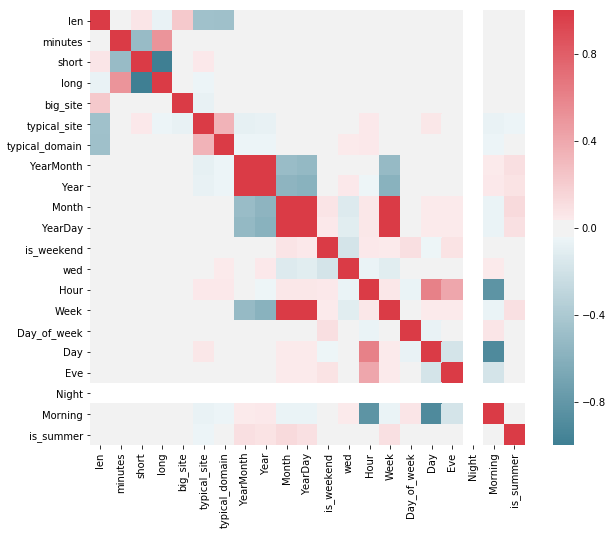

In [42]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
# night вообще useless, week сильная корреляция с month, yearday

In [48]:
df2.drop(['Week','Month','Year'], axis=1, inplace=True)

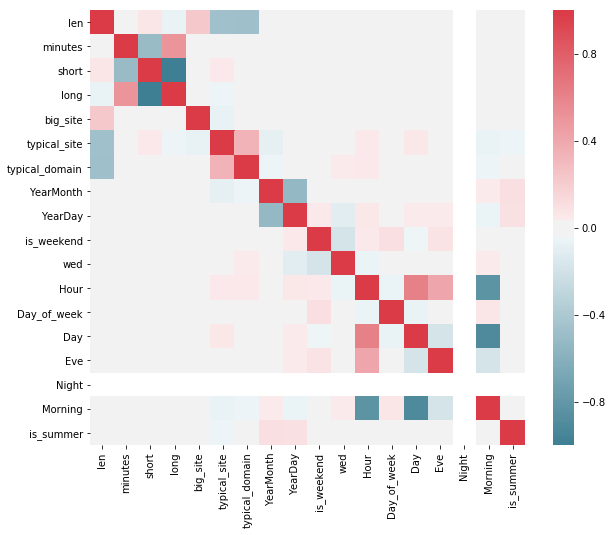

In [51]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [43]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df2.columns[columns]
df2 = df2[selected_columns]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 22 but corresponding boolean dimension is 21

In [52]:
corr[corr > 0.9]

,len,minutes,short,long,big_site,typical_site,typical_domain,YearMonth,YearDay,is_weekend,wed,Hour,Day_of_week,Day,Eve,Night,Morning,is_summer
len,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
minutes,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
short,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
long,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
big_site,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
typical_site,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
typical_domain,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearMonth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearDay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_weekend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
